# Evaluation of Deep Convolutional Neural Networks for Automatic Classification of Common Maternal Fetal Ultrasound Planes
## This notebook made by 
oussama Yousr: https://www.linkedin.com/in/oussamayousr/
Salah Eddine El Mouslih: https://www.linkedin.com/in/salah-eddine-el-mouslih/ 
yassine zouhri: https://www.linkedin.com/in/zouhri-yassine/
hamza gaoui: https://www.linkedin.com/in/hamza-gaoui-74a8a0205
Yulv: https://github.com/Yulv-git

## Dataset Upload

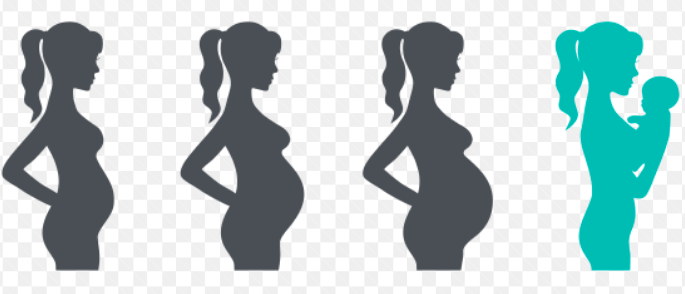<br>

> Ultrasound (US) examination is an essential tool to monitor fetus and mother along pregnancy, providing an
> economic and non-invasive way to observe the development of all fetal organs and maternal structures. Several
> measures obtained from maternal-fetal scans are commonly used to monitor fetal growth

In this Project, We are going to use a large dataset of routinely acquired maternal-fetal screening ultrasound images.

> All images were manually labeled
> by an expert maternal fetal clinician. Images were divided into 6 classes: four of the most widely used
> fetal anatomical planes (Abdomen, Brain, Femur and Thorax), the mother’s cervix (widely used for
> prematurity screening) and a general category to include any other less common image plane

In [ ]:
!wget https://zenodo.org/record/3904280/files/FETAL_PLANES_ZENODO.zip?download=1

In [ ]:
# !mv ./FETAL_PLANES_ZENODO.zip?download=1 ./dataset.zip

## Unzip the Dataset

In [ ]:
!unzip  ../input/deep-learning-project/FETAL_PLANES_ZENODO.zip?download=1

## The Platform that we are going to use to track our Model Training is W&B

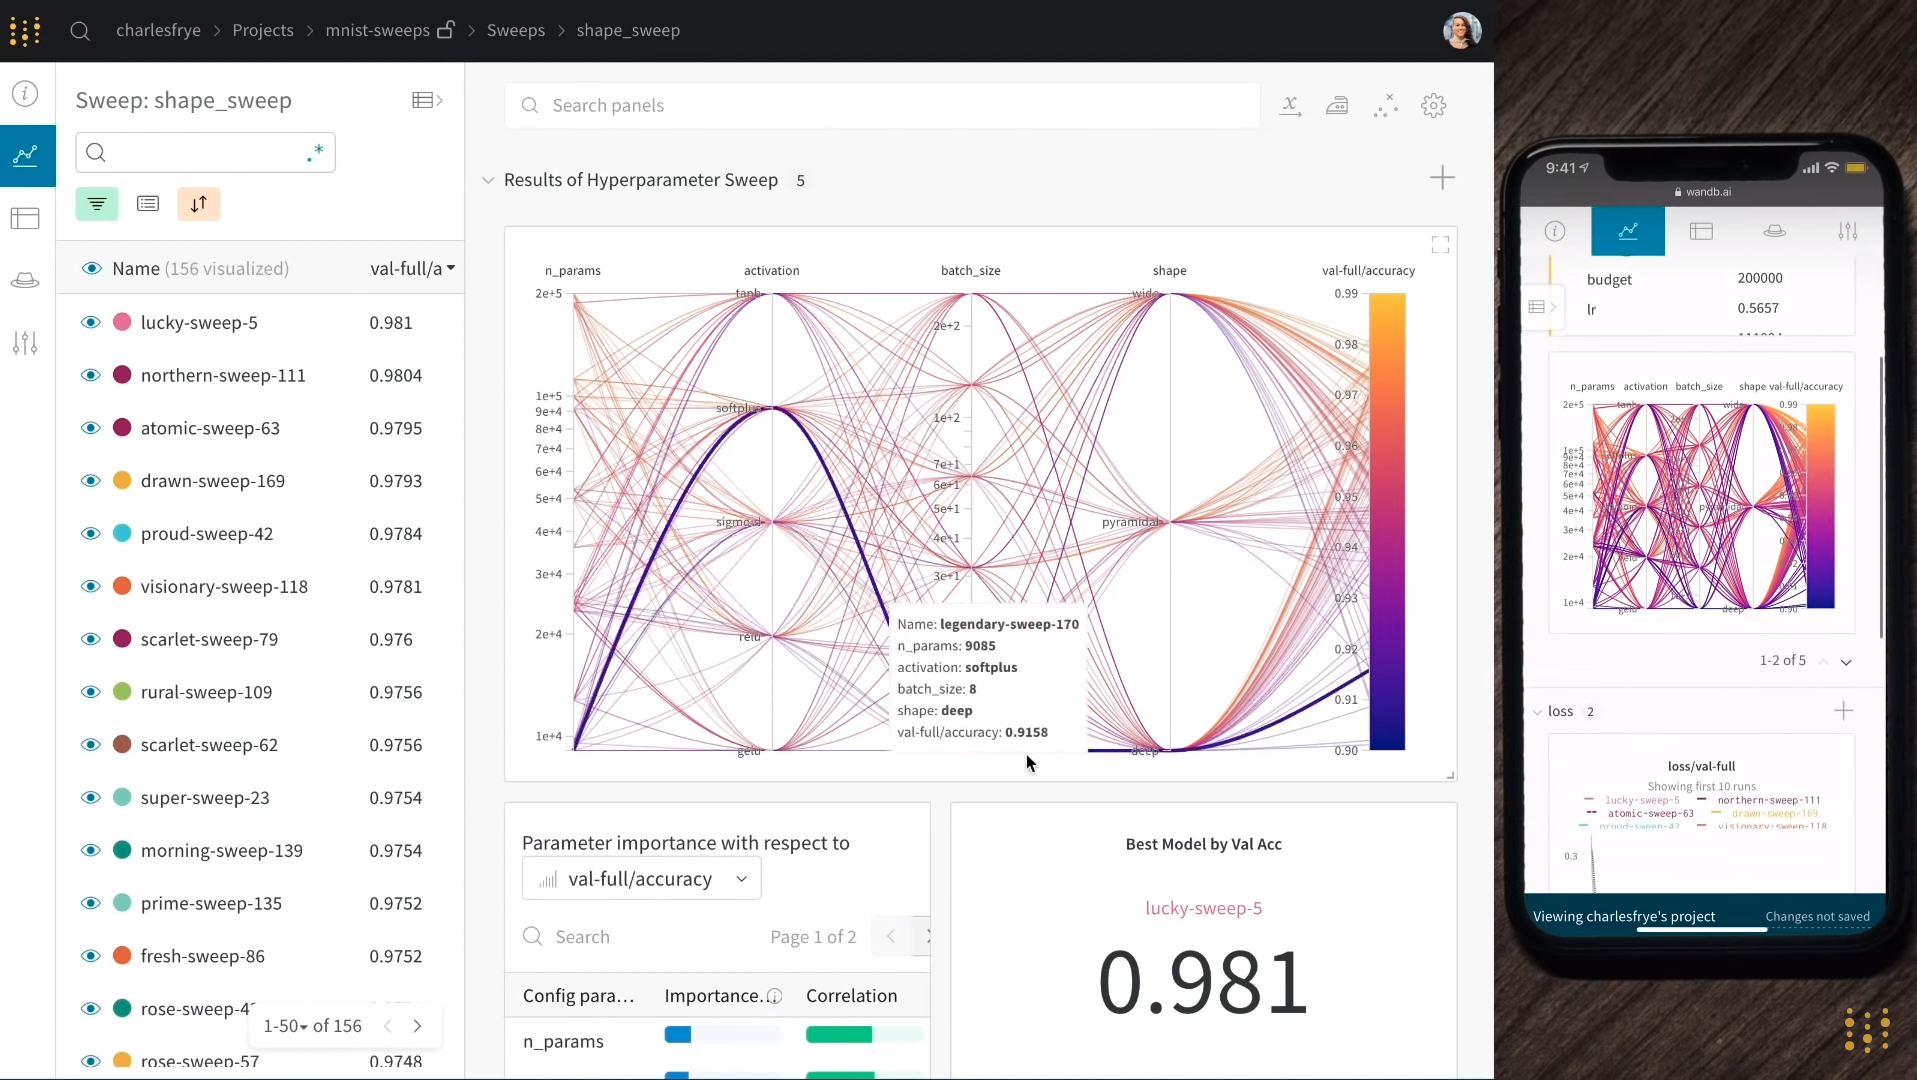

### W&B helps you visualize your model performance and predictions, find the best models fast and share insights learned from your models. Here are a few use cases in which W&B can be specially useful for Kagglers:

* Track and compare models - track your experiments easily, test out hypotheses fast and iterate quickly to find the best model
* Visualize model performance for debugging - see how models are performing in real time and debug them
* Efficient hyperparameter search - find the best model faster using sweeps (distributed to many agents!)
* Resource efficient model training - be efficient with model training and share key insights with my teammates and the Kaggle community

## Install Weights nad Baises Libraries on Kaggle

In [ ]:
!pip install wandb

## Import all the required Libraries

In [7]:
import os
import sys 
import json
import random
import collections
import time
import re
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom as dicom
import tensorflow as tf
import wandb
from sklearn.model_selection import train_test_split
from keras_preprocessing.image.dataframe_iterator import DataFrameIterator
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from keras.utils import data_utils
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.core import Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D,GlobalAveragePooling2D
from glob import glob
from keras import backend as K
from tensorflow.keras.models import load_model
from wandb.keras import WandbCallback

### My Weights and baises Key to link the Notebook To the platform

In [ ]:
wandb.login(key = "6e8945216f101fea1ca04d18131e4318e57780c8")

## Initialise or track on specific project

In [ ]:
wandb.init(project="Resnet-Tracking", entity="oussamayousr")

## Pre-processing and EDA 

In [ ]:
wandb_callback = wandb.keras.WandbCallback(log_weights=True)

## List Data image on an array 

In [14]:
list_images = os.listdir('../../data/FETAL_PLANES_DB/Images')

In [15]:
list_images[0]

'Patient00866_Plane4_2_of_4.png'

In [16]:
print(type(list_images))
len(list_images)

<class 'list'>


12400

## show an image from the dataset

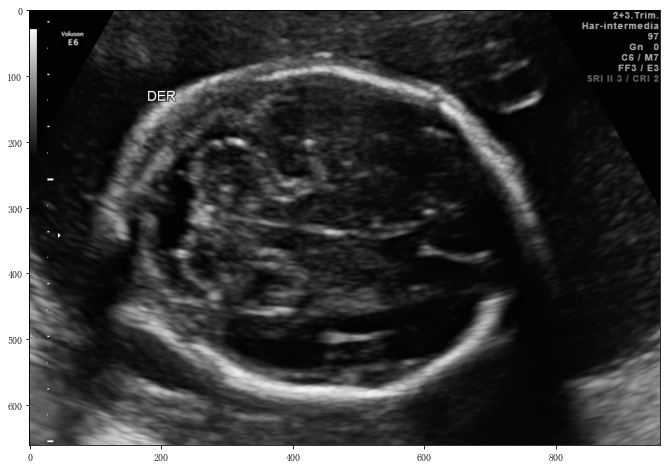

In [18]:
image = cv2.imread("../../data/FETAL_PLANES_DB/Images/"+list_images[666])
plt.figure(figsize=(12,8))
plt.imshow(image)

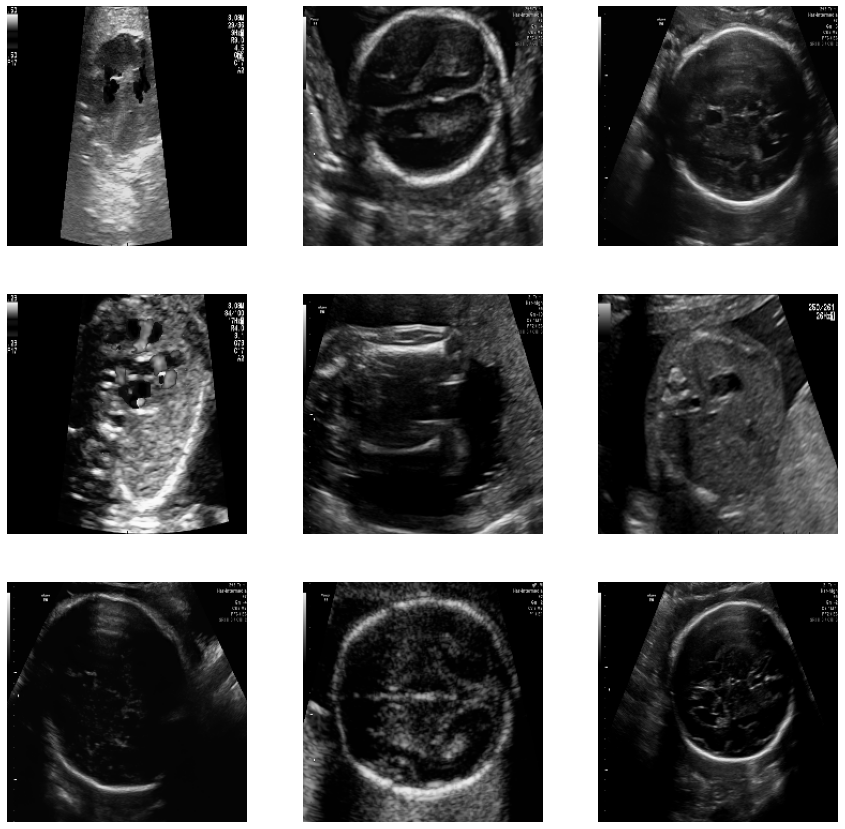

In [19]:
train_data = np.array([]).reshape(0, 224, 224, 3)
plt.figure(figsize=(15, 15))
for i in np.arange(9) :
    data = cv2.imread("../../data/FETAL_PLANES_DB/Images/"+list_images[i+100])
    data = cv2.resize(data, (224, 224))
    data = data.reshape((1, 224, 224, 3))
    train_data = np.vstack([train_data, data])
    plt.subplot(3, 3, i+1)
    plt.imshow(data[0], cmap='nipy_spectral_r')
    plt.axis('off')

In [ ]:
!pip install openpyxl

## load the Dataframe that containes All the information about the Data 

In [28]:
import pandas as pd
file_name = '../../data/FETAL_PLANES_DB/FETAL_PLANES_DB_data.xlsx' 
df = pd.read_excel(file_name, index_col=0, engine='openpyxl')
df

Patient_num          Plane     Brain_plane  \
Image_name                                                                
Patient00001_Plane1_1_of_15            1          Other     Not A Brain   
Patient00001_Plane1_2_of_15            1          Other     Not A Brain   
Patient00001_Plane1_3_of_15            1          Other     Not A Brain   
Patient00001_Plane1_4_of_15            1          Other     Not A Brain   
Patient00001_Plane1_5_of_15            1          Other     Not A Brain   
...                                  ...            ...             ...   
Patient01791_Plane5_1_of_1          1791    Fetal femur     Not A Brain   
Patient01792_Plane2_1_of_1          1792  Fetal abdomen     Not A Brain   
Patient01792_Plane3_1_of_1          1792    Fetal brain  Trans-thalamic   
Patient01792_Plane5_1_of_1          1792    Fetal femur     Not A Brain   
Patient01792_Plane6_1_of_1          1792   Fetal thorax     Not A Brain   

                            Operator   US_Machine  Train   
Image_name                                                 
Patient00001_Plane1_1_of_15    Other        Aloka       1  
Patient00001_Plane1_2_of_15    Other        Aloka       1  
Patient00001_Plane1_3_of_15    Other        Aloka       1  
Patient00001_Plane1_4_of_15    Other        Aloka       1  
Patient00001_Plane1_5_of_15    Other        Aloka       1  
...                              ...          ...     ...  
Patient01791_Plane5_1_of_1     Other  Voluson S10       0  
Patient01792_Plane2_1_of_1     Other   Voluson E6       0  
Patient01792_Plane3_1_of_1     Other   Voluson E6       0  
Patient01792_Plane5_1_of_1     Other   Voluson E6       0  
Patient01792_Plane6_1_of_1     Other   Voluson E6       0  

[12400 rows x 6 columns]

## change the Dataframe index

In [29]:
df["Image_name"] = df.index

In [30]:
df

Patient_num          Plane     Brain_plane  \
Image_name                                                                
Patient00001_Plane1_1_of_15            1          Other     Not A Brain   
Patient00001_Plane1_2_of_15            1          Other     Not A Brain   
Patient00001_Plane1_3_of_15            1          Other     Not A Brain   
Patient00001_Plane1_4_of_15            1          Other     Not A Brain   
Patient00001_Plane1_5_of_15            1          Other     Not A Brain   
...                                  ...            ...             ...   
Patient01791_Plane5_1_of_1          1791    Fetal femur     Not A Brain   
Patient01792_Plane2_1_of_1          1792  Fetal abdomen     Not A Brain   
Patient01792_Plane3_1_of_1          1792    Fetal brain  Trans-thalamic   
Patient01792_Plane5_1_of_1          1792    Fetal femur     Not A Brain   
Patient01792_Plane6_1_of_1          1792   Fetal thorax     Not A Brain   

                            Operator   US_Machine  Train   \
Image_name                                                  
Patient00001_Plane1_1_of_15    Other        Aloka       1   
Patient00001_Plane1_2_of_15    Other        Aloka       1   
Patient00001_Plane1_3_of_15    Other        Aloka       1   
Patient00001_Plane1_4_of_15    Other        Aloka       1   
Patient00001_Plane1_5_of_15    Other        Aloka       1   
...                              ...          ...     ...   
Patient01791_Plane5_1_of_1     Other  Voluson S10       0   
Patient01792_Plane2_1_of_1     Other   Voluson E6       0   
Patient01792_Plane3_1_of_1     Other   Voluson E6       0   
Patient01792_Plane5_1_of_1     Other   Voluson E6       0   
Patient01792_Plane6_1_of_1     Other   Voluson E6       0   

                                              Image_name  
Image_name                                                
Patient00001_Plane1_1_of_15  Patient00001_Plane1_1_of_15  
Patient00001_Plane1_2_of_15  Patient00001_Plane1_2_of_15  
Patient00001_Plane1_3_of_15  Patient00001_Plane1_3_of_15  
Patient00001_Plane1_4_of_15  Patient00001_Plane1_4_of_15  
Patient00001_Plane1_5_of_15  Patient00001_Plane1_5_of_15  
...                                                  ...  
Patient01791_Plane5_1_of_1    Patient01791_Plane5_1_of_1  
Patient01792_Plane2_1_of_1    Patient01792_Plane2_1_of_1  
Patient01792_Plane3_1_of_1    Patient01792_Plane3_1_of_1  
Patient01792_Plane5_1_of_1    Patient01792_Plane5_1_of_1  
Patient01792_Plane6_1_of_1    Patient01792_Plane6_1_of_1  

[12400 rows x 7 columns]

## Reset the Dataframe indexes


In [31]:
df.reset_index(drop=True, inplace=True)

In [32]:
df

Patient_num          Plane     Brain_plane Operator   US_Machine  \
0                1          Other     Not A Brain    Other        Aloka   
1                1          Other     Not A Brain    Other        Aloka   
2                1          Other     Not A Brain    Other        Aloka   
3                1          Other     Not A Brain    Other        Aloka   
4                1          Other     Not A Brain    Other        Aloka   
...            ...            ...             ...      ...          ...   
12395         1791    Fetal femur     Not A Brain    Other  Voluson S10   
12396         1792  Fetal abdomen     Not A Brain    Other   Voluson E6   
12397         1792    Fetal brain  Trans-thalamic    Other   Voluson E6   
12398         1792    Fetal femur     Not A Brain    Other   Voluson E6   
12399         1792   Fetal thorax     Not A Brain    Other   Voluson E6   

       Train                    Image_name  
0           1  Patient00001_Plane1_1_of_15  
1           1  Patient00001_Plane1_2_of_15  
2           1  Patient00001_Plane1_3_of_15  
3           1  Patient00001_Plane1_4_of_15  
4           1  Patient00001_Plane1_5_of_15  
...       ...                          ...  
12395       0   Patient01791_Plane5_1_of_1  
12396       0   Patient01792_Plane2_1_of_1  
12397       0   Patient01792_Plane3_1_of_1  
12398       0   Patient01792_Plane5_1_of_1  
12399       0   Patient01792_Plane6_1_of_1  

[12400 rows x 7 columns]

In [33]:
df.rename(columns={'Train ': 'Train'}, inplace=True)
df.Train[df.Train == 0]

1454     0
1455     0
1456     0
1457     0
1458     0
        ..
12395    0
12396    0
12397    0
12398    0
12399    0
Name: Train, Length: 5271, dtype: int64

In [34]:
df.Image_name = "../../data/FETAL_PLANES_DB/Images/"+df.Image_name+".png"

In [35]:
df

Patient_num          Plane     Brain_plane Operator   US_Machine  \
0                1          Other     Not A Brain    Other        Aloka   
1                1          Other     Not A Brain    Other        Aloka   
2                1          Other     Not A Brain    Other        Aloka   
3                1          Other     Not A Brain    Other        Aloka   
4                1          Other     Not A Brain    Other        Aloka   
...            ...            ...             ...      ...          ...   
12395         1791    Fetal femur     Not A Brain    Other  Voluson S10   
12396         1792  Fetal abdomen     Not A Brain    Other   Voluson E6   
12397         1792    Fetal brain  Trans-thalamic    Other   Voluson E6   
12398         1792    Fetal femur     Not A Brain    Other   Voluson E6   
12399         1792   Fetal thorax     Not A Brain    Other   Voluson E6   

       Train                                         Image_name  
0          1  ../../data/FETAL_PLANES_DB/Images/Patient00001...  
1          1  ../../data/FETAL_PLANES_DB/Images/Patient00001...  
2          1  ../../data/FETAL_PLANES_DB/Images/Patient00001...  
3          1  ../../data/FETAL_PLANES_DB/Images/Patient00001...  
4          1  ../../data/FETAL_PLANES_DB/Images/Patient00001...  
...      ...                                                ...  
12395      0  ../../data/FETAL_PLANES_DB/Images/Patient01791...  
12396      0  ../../data/FETAL_PLANES_DB/Images/Patient01792...  
12397      0  ../../data/FETAL_PLANES_DB/Images/Patient01792...  
12398      0  ../../data/FETAL_PLANES_DB/Images/Patient01792...  
12399      0  ../../data/FETAL_PLANES_DB/Images/Patient01792...  

[12400 rows x 7 columns]

## Our Dataset Classes

In [36]:
df.Plane.unique()

array(['Other', 'Maternal cervix', 'Fetal abdomen', 'Fetal brain',
       'Fetal femur', 'Fetal thorax'], dtype=object)

In [ ]:
# df['Plane'] = df['Plane'].map({'Other': 0, 'Maternal cervix': 1,'Fetal abdomen': 2,'Fetal brain':3,
#                                'Fetal femur' : 4,'Fetal thorax':5})

## shuffle the Dataframe rows

In [37]:
df = df.sample(frac=1).reset_index(drop=True)

In [38]:
df

Patient_num            Plane     Brain_plane Operator  US_Machine  \
0             1651  Maternal cervix     Not A Brain    Other  Voluson E6   
1             1645     Fetal thorax     Not A Brain    Op. 2  Voluson E6   
2               80  Maternal cervix     Not A Brain    Other       Other   
3              811      Fetal brain  Trans-thalamic    Op. 3       Aloka   
4             1486            Other     Not A Brain    Op. 3       Aloka   
...            ...              ...             ...      ...         ...   
12395         1137  Maternal cervix     Not A Brain    Op. 2  Voluson E6   
12396         1280      Fetal femur     Not A Brain    Op. 1  Voluson E6   
12397          874      Fetal brain  Trans-thalamic    Op. 3       Aloka   
12398         1580    Fetal abdomen     Not A Brain    Op. 1  Voluson E6   
12399          757      Fetal femur     Not A Brain    Op. 1  Voluson E6   

       Train                                         Image_name  
0          0  ../../data/FETAL_PLANES_DB/Images/Patient01651...  
1          0  ../../data/FETAL_PLANES_DB/Images/Patient01645...  
2          1  ../../data/FETAL_PLANES_DB/Images/Patient00080...  
3          1  ../../data/FETAL_PLANES_DB/Images/Patient00811...  
4          0  ../../data/FETAL_PLANES_DB/Images/Patient01486...  
...      ...                                                ...  
12395      1  ../../data/FETAL_PLANES_DB/Images/Patient01137...  
12396      0  ../../data/FETAL_PLANES_DB/Images/Patient01280...  
12397      1  ../../data/FETAL_PLANES_DB/Images/Patient00874...  
12398      0  ../../data/FETAL_PLANES_DB/Images/Patient01580...  
12399      1  ../../data/FETAL_PLANES_DB/Images/Patient00757...  

[12400 rows x 7 columns]

## Exploratory Data Analysis

<AxesSubplot:>

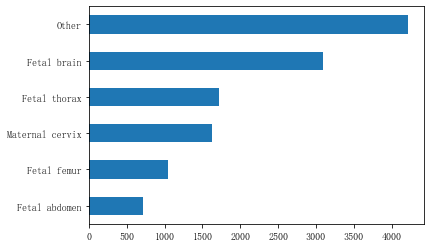

In [39]:
df.Plane.value_counts().sort_values().plot(kind = 'barh')

<AxesSubplot:>

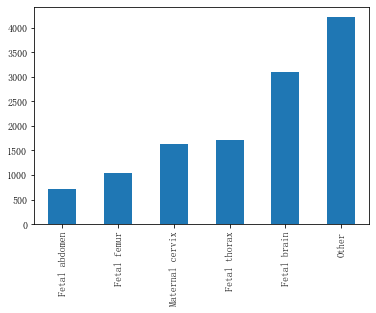

In [40]:
df.Plane.value_counts().sort_values().plot(kind = 'bar')

In [41]:
df.Plane.size

12400

## Split the Data

### Validation Data

In [42]:
 df[df["Train"] == 0]

Patient_num            Plane     Brain_plane Operator  US_Machine  \
0             1651  Maternal cervix     Not A Brain    Other  Voluson E6   
1             1645     Fetal thorax     Not A Brain    Op. 2  Voluson E6   
4             1486            Other     Not A Brain    Op. 3       Aloka   
6             1728    Fetal abdomen     Not A Brain    Op. 3       Aloka   
10            1686      Fetal femur     Not A Brain    Op. 1  Voluson E6   
...            ...              ...             ...      ...         ...   
12390         1289            Other     Not A Brain    Op. 3       Aloka   
12392         1679      Fetal femur     Not A Brain    Other  Voluson E6   
12393         1488      Fetal brain  Trans-thalamic    Other  Voluson E6   
12396         1280      Fetal femur     Not A Brain    Op. 1  Voluson E6   
12398         1580    Fetal abdomen     Not A Brain    Op. 1  Voluson E6   

       Train                                         Image_name  
0          0  ../../data/FETAL_PLANES_DB/Images/Patient01651...  
1          0  ../../data/FETAL_PLANES_DB/Images/Patient01645...  
4          0  ../../data/FETAL_PLANES_DB/Images/Patient01486...  
6          0  ../../data/FETAL_PLANES_DB/Images/Patient01728...  
10         0  ../../data/FETAL_PLANES_DB/Images/Patient01686...  
...      ...                                                ...  
12390      0  ../../data/FETAL_PLANES_DB/Images/Patient01289...  
12392      0  ../../data/FETAL_PLANES_DB/Images/Patient01679...  
12393      0  ../../data/FETAL_PLANES_DB/Images/Patient01488...  
12396      0  ../../data/FETAL_PLANES_DB/Images/Patient01280...  
12398      0  ../../data/FETAL_PLANES_DB/Images/Patient01580...  

[5271 rows x 7 columns]

### Testing data

In [43]:
df_test = df[df["Train"] == 0]

### Training Data

In [44]:
df_train = df[df["Train"] == 1]

### Reset Indexes after Spliting the Data 

In [45]:
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [46]:
image_train_array = df_train.Image_name.to_numpy()
label_train_array = df_train.Plane.to_numpy()
image_test_array = df_test.Image_name.to_numpy()
label_test_array = df_test.Plane.to_numpy()

In [47]:
len(image_train_array)

7129

In [48]:
len(df[df.Train == 1].Image_name.to_numpy())

7129

>In this part of the notebook, we have used Two Methode to Generate Data, the first one using Sequence Class in Tensorflow that enable users to costumize their own Data Generators.
> and the Second method is Data generation using flow_from_dataframe.

## load data using tf.keras.utils.Sequence

In [49]:
class ImageFrameGenerator(tf.keras.utils.Sequence):  # Generates data for Keras.
    def __init__(self, train_ID, batch_size=1, image_list_path=image_train_array, label_list=label_train_array,
                 image_batch=32, dataset=df_test, dim=(256,256), shuffle=True):
        self.batch_size = batch_size
        self.image_list_path = image_list_path
        self.label_list = label_list
        self.image_batch = image_batch
        self.train_ID = train_ID   
        self.dataset = dataset
        self.shuffle = shuffle
        self.dim = dim
        self.on_epoch_end()

    def __len__(self):  # Denotes the number of batches per epoch.
        return int(np.floor(len(self.train_ID)))

    def __getitem__(self, index):  # Generate one batch of data.
        # Generate indexes of the batch.
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs.
        list_IDs_temp = [k for k in indexes]
        # list_IDs_temp = [20]
        # Generate data.
        data, labels = self.__data_generation(list_IDs_temp)

        return data/255, labels

    def on_epoch_end(self):  # Updates indexes after each epoch.
        self.indexes = np.arange(len(self.train_ID))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):  # Generates data containing batch_size samples.  # X: (n_samples, *dim, n_channels)
        data = np.array([]).reshape(0,256,256,3)
        labels = np.array([])
        first_index = list_IDs_temp[0] * self.image_batch
        for i in np.arange(32):
            # img = tf.keras.preprocessing.image.array_to_img(data)
            image_name = f"./Images/{self.image_list_path[first_index+i]}.png" 
            image = cv2.imread(image_name)
            image = cv2.resize(image,(256,256))
            image = image.reshape((1,256,256,3))
            data = np.vstack([data,image])
            labels = np.append(labels,self.label_list[first_index+i])

        return data, labels

In [52]:
image = cv2.imread("../../data/FETAL_PLANES_DB/Images/Patient01063_Plane5_2_of_2.png")

## Image Data generation using Sequence 

In [53]:
# Parameters
train_params = {'dim':(256, 256), 'batch_size':1, 'shuffle':False, 'dataset':df_train,
                'image_list_path':image_train_array, 'label_list':label_train_array}
test_params = {'dim':(256,256), 'batch_size':1, 'shuffle':False, 'dataset':df_test,
                'image_list_path':image_test_array, 'label_list':label_test_array}
training_generator = ImageFrameGenerator(np.arange(df_train.Train.size//32 - 1), **train_params)
testing_generator = ImageFrameGenerator(np.arange(df_test.Train.size//32 - 1), **test_params)

In [54]:
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

In [ ]:
x, y = training_generator.__getitem__(0)

In [ ]:
x.shape

## Image Data Generation using flow_from_dataframe

In [58]:
DIM = 256
NB_CHANNELS = 3
NB_CLASSES = 6

In [59]:
df_test

Patient_num            Plane     Brain_plane Operator  US_Machine  \
0            1651  Maternal cervix     Not A Brain    Other  Voluson E6   
1            1645     Fetal thorax     Not A Brain    Op. 2  Voluson E6   
2            1486            Other     Not A Brain    Op. 3       Aloka   
3            1728    Fetal abdomen     Not A Brain    Op. 3       Aloka   
4            1686      Fetal femur     Not A Brain    Op. 1  Voluson E6   
...           ...              ...             ...      ...         ...   
5266         1289            Other     Not A Brain    Op. 3       Aloka   
5267         1679      Fetal femur     Not A Brain    Other  Voluson E6   
5268         1488      Fetal brain  Trans-thalamic    Other  Voluson E6   
5269         1280      Fetal femur     Not A Brain    Op. 1  Voluson E6   
5270         1580    Fetal abdomen     Not A Brain    Op. 1  Voluson E6   

      Train                                         Image_name  
0         0  ../../data/FETAL_PLANES_DB/Images/Patient01651...  
1         0  ../../data/FETAL_PLANES_DB/Images/Patient01645...  
2         0  ../../data/FETAL_PLANES_DB/Images/Patient01486...  
3         0  ../../data/FETAL_PLANES_DB/Images/Patient01728...  
4         0  ../../data/FETAL_PLANES_DB/Images/Patient01686...  
...     ...                                                ...  
5266      0  ../../data/FETAL_PLANES_DB/Images/Patient01289...  
5267      0  ../../data/FETAL_PLANES_DB/Images/Patient01679...  
5268      0  ../../data/FETAL_PLANES_DB/Images/Patient01488...  
5269      0  ../../data/FETAL_PLANES_DB/Images/Patient01280...  
5270      0  ../../data/FETAL_PLANES_DB/Images/Patient01580...  

[5271 rows x 7 columns]

In [60]:
def get_train_generator(df_train,df_test, image_dir = None, x_col = "Image_name", y_cols = "Plane", 
                        shuffle=True, batch_size=64, seed=1, target_w = 256, target_h = 256):
    ### Perform data augmentation here
    image_generator = ImageDataGenerator(rescale=1/255 ,rotation_range = 5, shear_range = 0.02,zoom_range = 0.02,
                                         samplewise_center=True, samplewise_std_normalization= True)
    
    ### Create the image generator

    train_generator=image_generator.flow_from_dataframe(
    dataframe=df_train,
    directory=None,
    x_col="Image_name",
    y_col="Plane",
    subset="training",
    batch_size=batch_size,
    seed=seed,
    shuffle=shuffle,
    class_mode="categorical",
    target_size=(target_w,target_h)
)
    valid_generator=image_generator.flow_from_dataframe(
    dataframe=df_test,
    directory=None,
    x_col="Image_name",
    y_col="Plane",
    subset="training",
    batch_size=batch_size,
    seed=seed,
    shuffle=shuffle,
    class_mode="categorical",
    target_size=(target_w,target_h)
)
    
    return train_generator, valid_generator

In [62]:
train_generator, valid_generator = get_train_generator(df_train,df_test, image_dir = None, x_col = "Image_name", y_cols = "Plane", 
                        shuffle=True, batch_size=64, seed=1, target_w = 256, target_h = 256)

Found 7129 validated image filenames belonging to 6 classes.
Found 5271 validated image filenames belonging to 6 classes.


> > ## the First model that we've build is a Baseline model, and Since the is somehow unbalanced, we've tried to Evaluate our models using multiple metrics, F1,Precision, Recall ...

## Baseline Model 

In [ ]:
base_model = Sequential()
base_model.add(Conv2D(32, (3, 3), padding="same",input_shape = (DIM , DIM , NB_CHANNELS)))
base_model.add(Activation("relu"))
base_model.add(BatchNormalization(axis=1))
base_model.add(MaxPooling2D(pool_size=(3, 3)))
base_model.add(Conv2D(64, (3, 3), padding="same"))
base_model.add(Activation("relu"))
base_model.add(BatchNormalization(axis=1))
base_model.add(Conv2D(64, (3, 3), padding="same"))
base_model.add(Activation("relu"))
base_model.add(BatchNormalization(axis=1))
base_model.add(MaxPooling2D(pool_size=(2, 2)))
base_model.add(Conv2D(128, (3, 3), padding="same"))
base_model.add(Activation("relu"))
base_model.add(BatchNormalization(axis=1))
base_model.add(Conv2D(128, (3, 3), padding="same"))
base_model.add(Activation("relu"))
base_model.add(BatchNormalization(axis=1))
base_model.add(MaxPooling2D(pool_size=(2, 2)))
base_model.add(Flatten())
base_model.add(Dense(1024))
base_model.add(Activation("relu"))
base_model.add(BatchNormalization())
base_model.add(Dense(6))
base_model.add(Activation("softmax"))
base_model.build((0,256,256,3))
base_model.summary()

## Plot the model Architecture 

In [ ]:

tf.keras.utils.plot_model(
    base_model, to_file='base_model.png'
)

## Metrics Implementation 

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


## <p>Model Training :<strong> We have used Adam Optimizer, great Optimizer for Classification Tasks, Then we've used a Learning-rate Decay so we avoid the Stagnation of the model performance during training, for the loss, since we're using the softmax as the activation function of the head Layer and the Labels are hot-encoded we need to use the Categorical_Crossentropy loss for 15 Epochs</p>

In [ ]:

learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy',
                                            patience = 2,
                                            verbose=1,
                                            factor=0.1,
                                            min_lr=0.000001)

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)


base_model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy',f1_m,precision_m, recall_m])
history = base_model.fit(train_generator,validation_data = valid_generator, epochs = 15,callbacks=[learning_rate_reduction,wandb_callback])


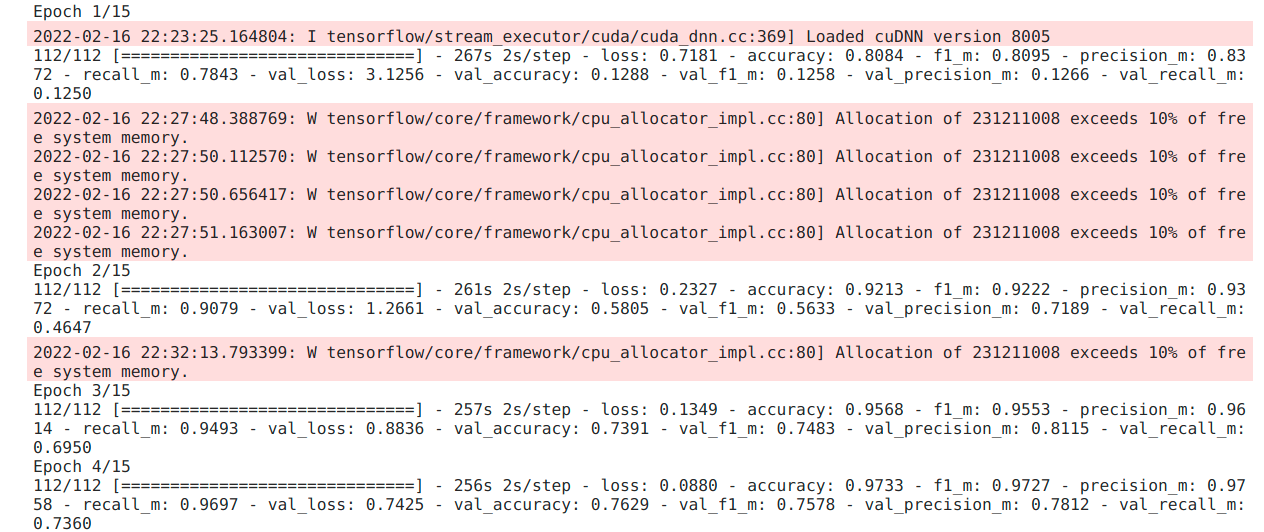

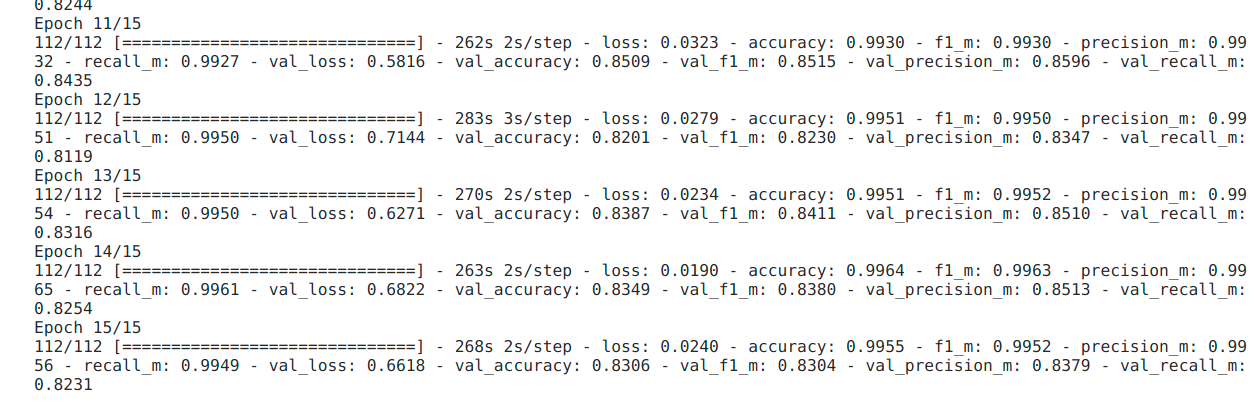


## We can Clearly see the Accuracy is Good for both the Training and validation Data,so as a baseline Model, it has perfectly done its job

## Plot The history of the training Process 

In [ ]:
from matplotlib import pyplot

# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

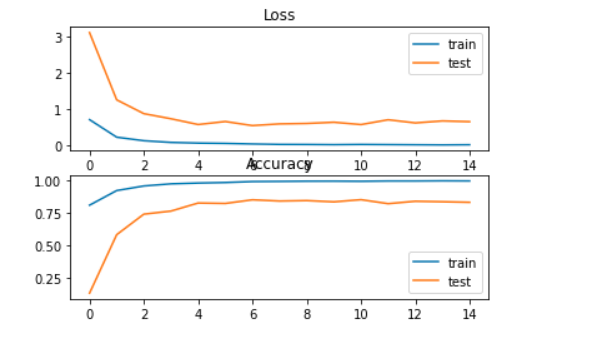

### save the model 

In [ ]:

path = './base_model'
base_model.save(path, save_format='tf')



### load the model

In [ ]:
model = tf.keras.models.load_model('./base_model', compile=False)

## Model training summary 
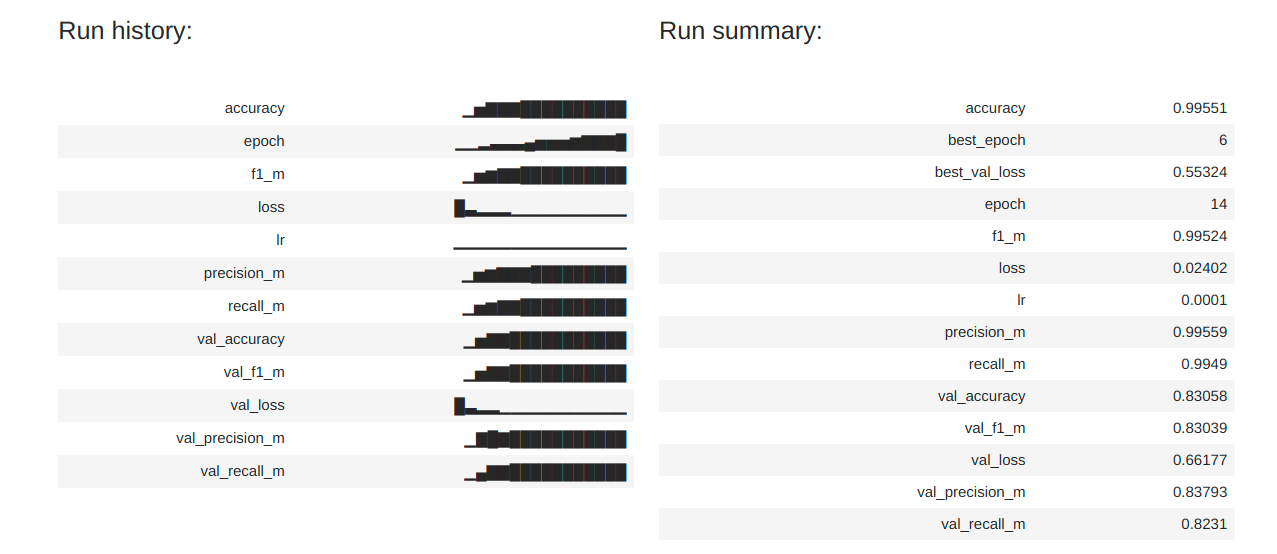

# EfficientNetB6

> ## load pre-trained EfficientNetB6  model with the imagNet Dataset
> ## 15 Epochs

## after using a base_line Model, then we've used the EfficientNet pretrained Model that enables us to improve the accuracy and the performance using Model Scaling 

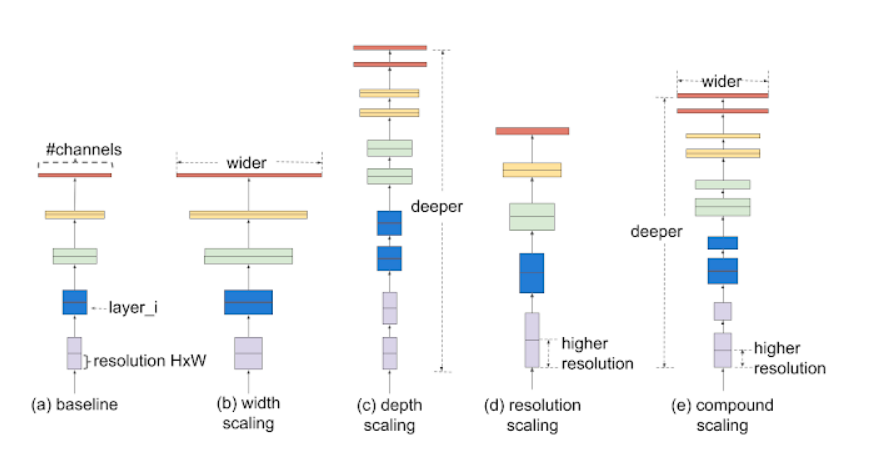

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB6
inputs = layers.Input(shape=(128, 128, 3))
outputs = EfficientNetB6(include_top=False, weights="imagenet")(inputs)
outputs = layers.Flatten()(outputs)
outputs = layers.Dense(512, activation = 'relu')(outputs)
outputs = layers.Dropout(0.2)(outputs)
outputs = layers.Dense(256 , activation = 'relu')(outputs)
outputs = layers.Dense(6 , activation = 'softmax')(outputs)
EfficientNet = tf.keras.Model(inputs, outputs)
EfficientNet.summary()

In [ ]:

tf.keras.utils.plot_model(
    EfficientNet, to_file='base_model.png'
)

In [ ]:
train_generator, valid_generator = get_train_generator(df_train,df_test, image_dir = None, x_col = "Image_name", y_cols = "Plane", 
                        shuffle=True, batch_size=32, seed=1, target_w = 128, target_h = 128)

In [ ]:

learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy',
                                            patience = 2,
                                            verbose=1,
                                            factor=0.1,
                                            min_lr=0.000001)

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

EfficientNet.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy',f1_m,precision_m, recall_m])
history = EfficientNet.fit(train_generator,validation_data = valid_generator, epochs = 15,callbacks=[learning_rate_reduction,wandb_callback])


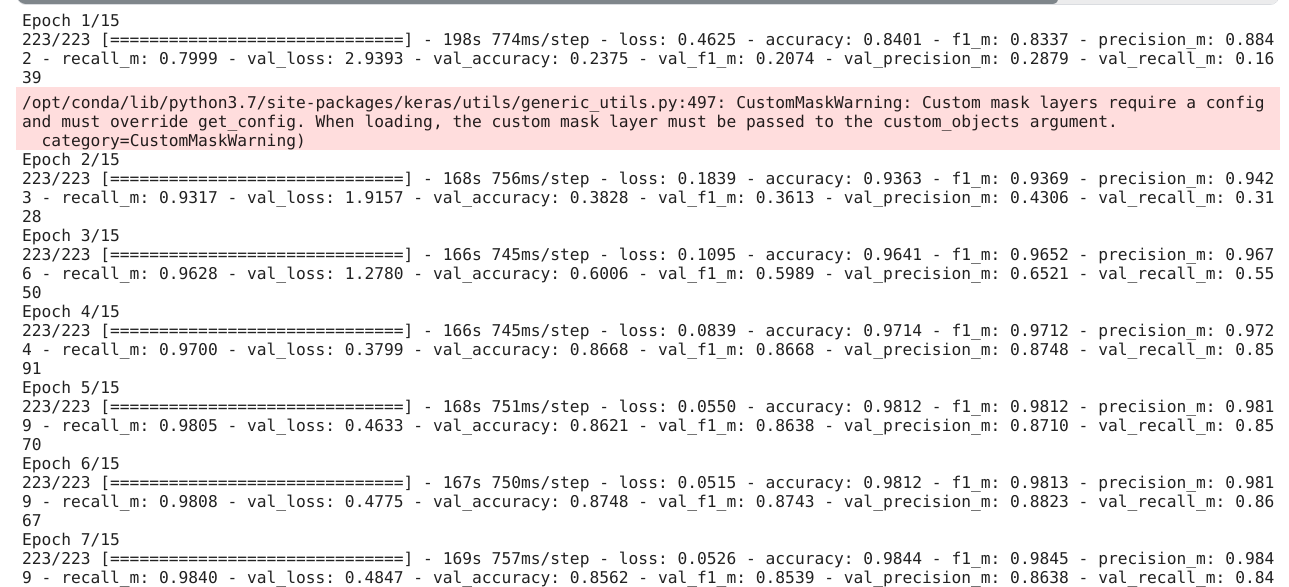
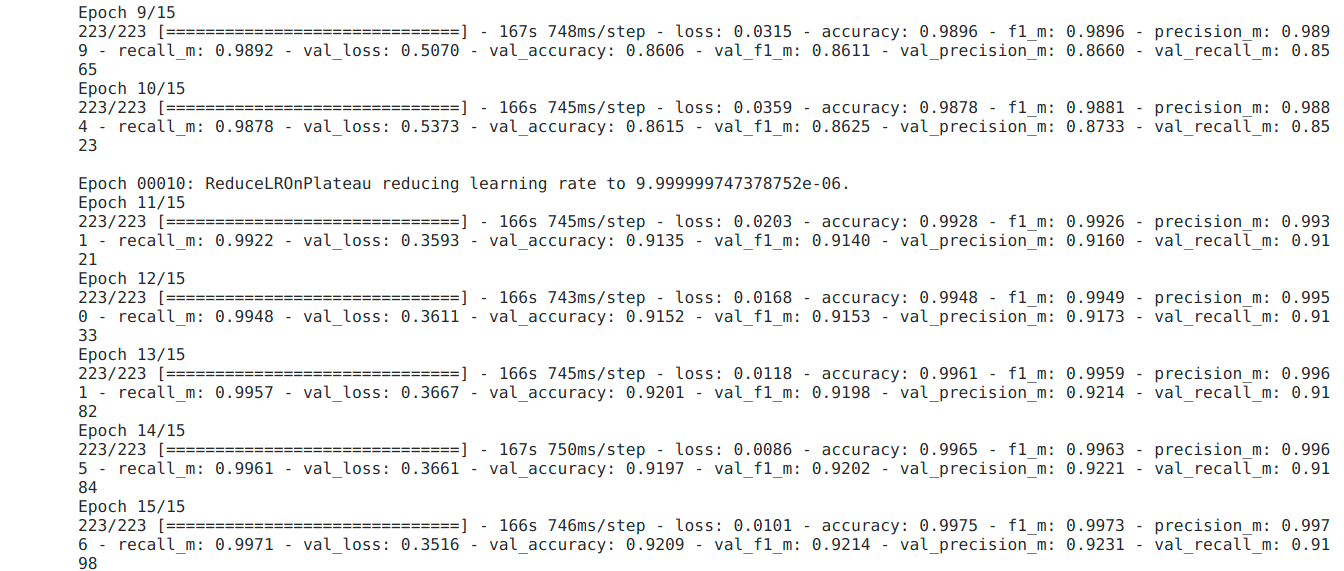

## The Model Outperform the Base-line Model by far !! 

In [ ]:
from matplotlib import pyplot

# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

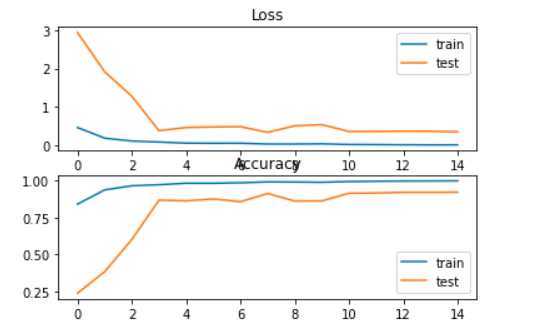

In [ ]:
from tensorflow.keras.models import load_model


### save the model 

In [ ]:

path = './efficientNet_model'
EfficientNet.save(path, save_format='tf')



### load the model

In [ ]:
model = tf.keras.models.load_model('./efficientNet_model', compile=False)

## Model training summary 


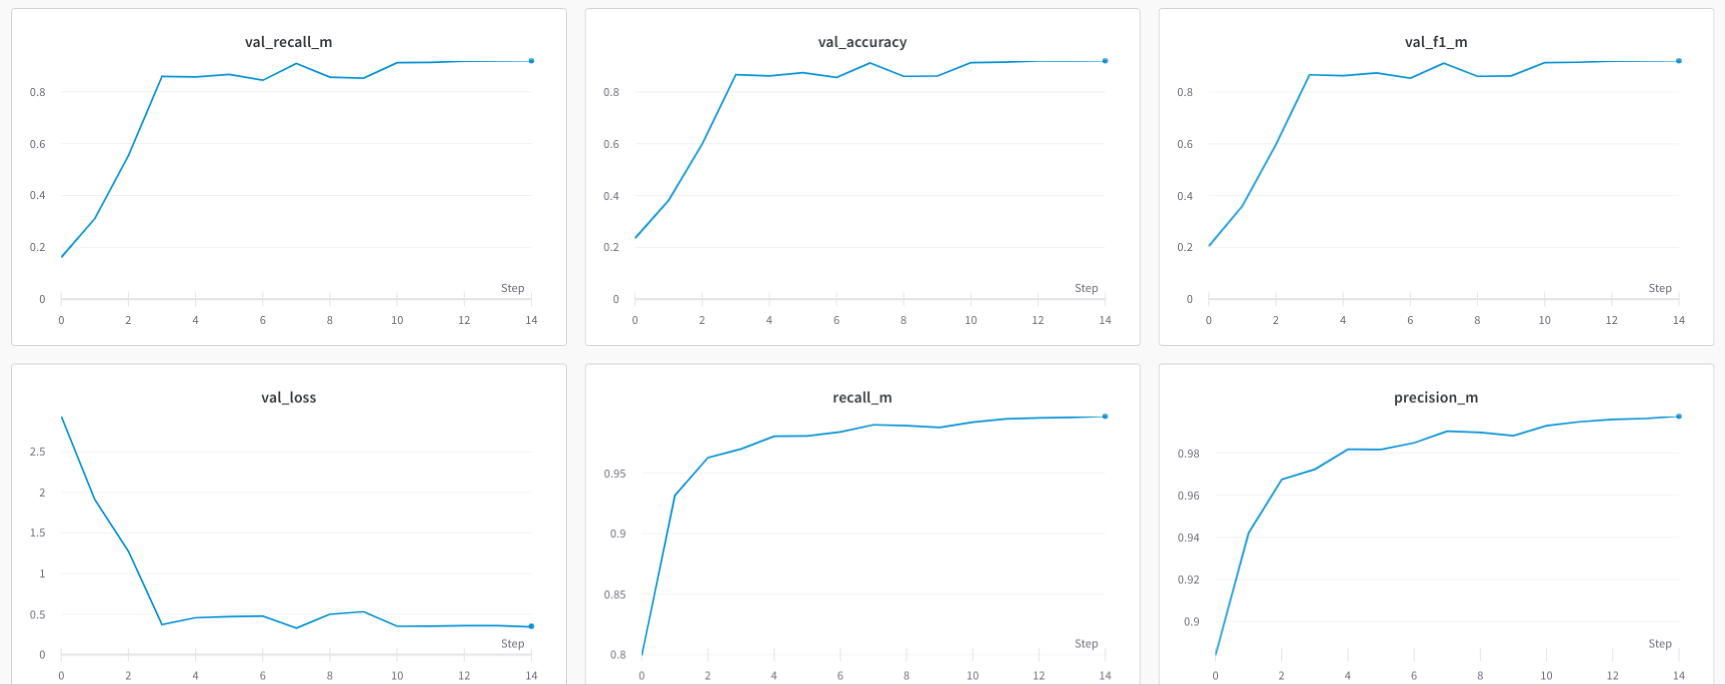

 ### here are the Validation Metrics 
 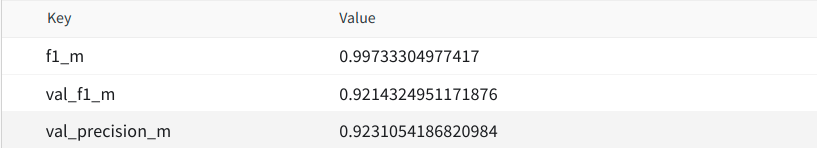

### the best model is saved now on Weights and Baises 

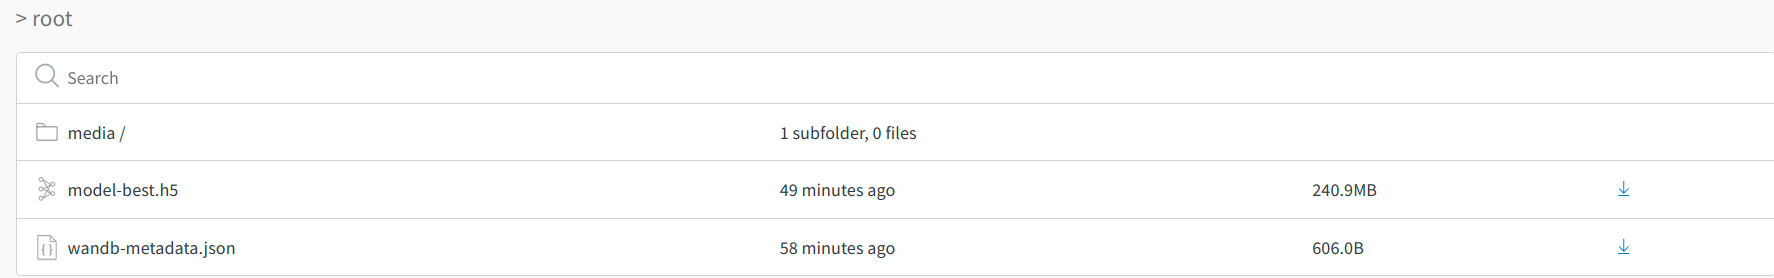

# Resnet50


## Resnet50 Architecture 

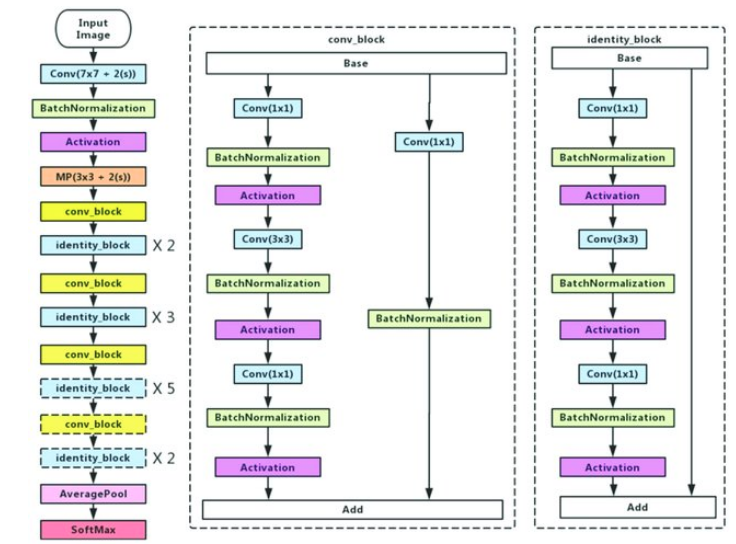

> ## we've Costumized the model by adding three Dense layers at the Top of the model, the model may need more than 50 Epochs to start seeing an incredible Result, Unfortantly we don't have enough ressources, so 20 Epochs was Fair enough.

In [ ]:
encoder_resnet50 = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(DIM,DIM ,NB_CHANNELS)) 
new_model = Sequential(name = 'encoder_resnet_50')
new_model.add(encoder_resnet50)
new_model.add(GlobalAveragePooling2D())
new_model.add(Dense(512))
new_model.add(Dense(256))
new_model.add(Dense(6, activation='softmax'))
resnet50 = new_model
resnet50.summary()

In [ ]:

tf.keras.utils.plot_model(
    resnet50, to_file='base_model.png'
)

In [ ]:
train_generator, valid_generator = get_train_generator(df_train,df_test, image_dir = None, x_col = "Image_name", y_cols = "Plane", 
                        shuffle=True, batch_size=64, seed=1, target_w = 256, target_h = 256)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience = 2,
                                            verbose=1,
                                            factor=0.1,
                                            min_lr=0.000001)

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

resnet50.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy',f1_m,precision_m, recall_m])
history = resnet50.fit(train_generator,validation_data = valid_generator, epochs = 20,callbacks=[learning_rate_reduction,wandb_callback])


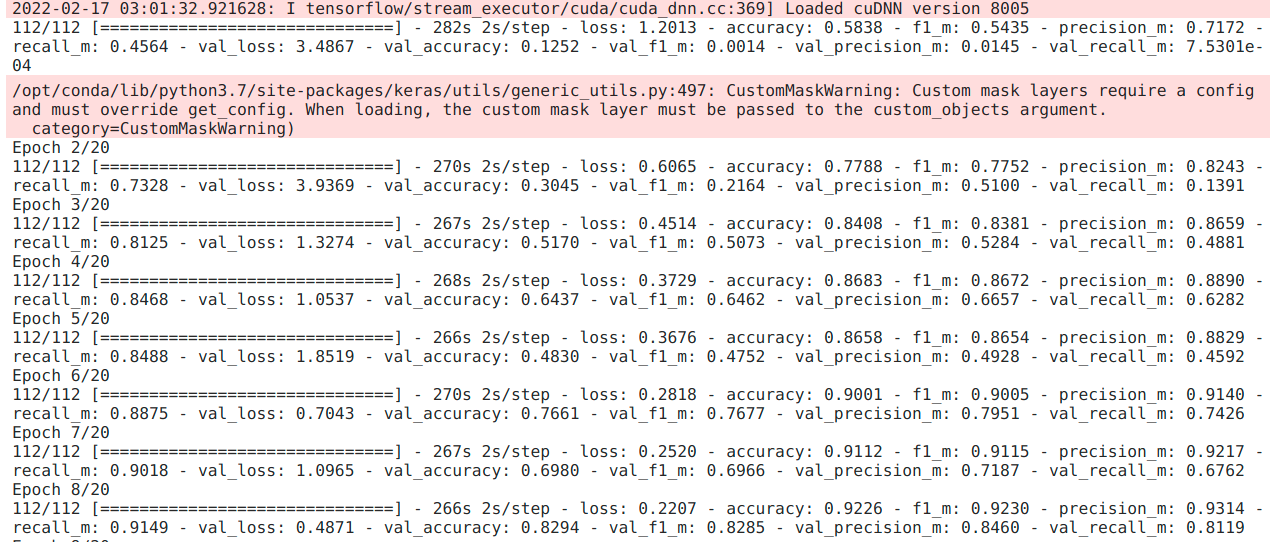

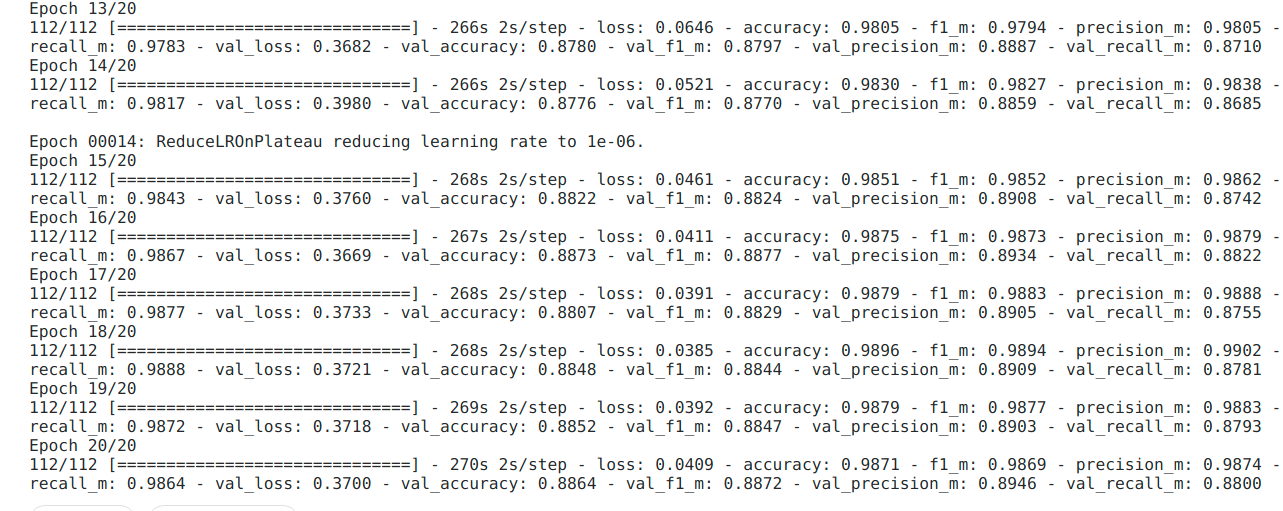

In [ ]:
resnet50.evaluate(valid_generator)

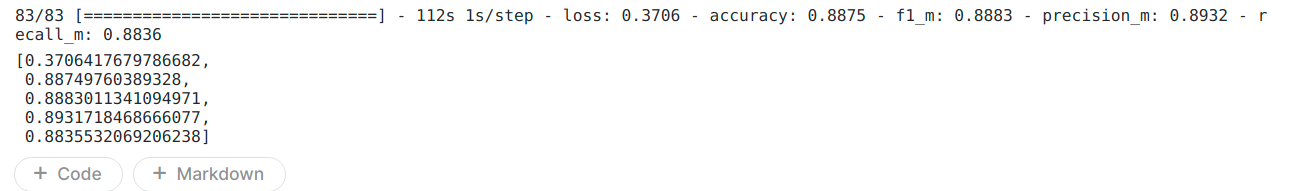

In [ ]:

from matplotlib import pyplot

# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

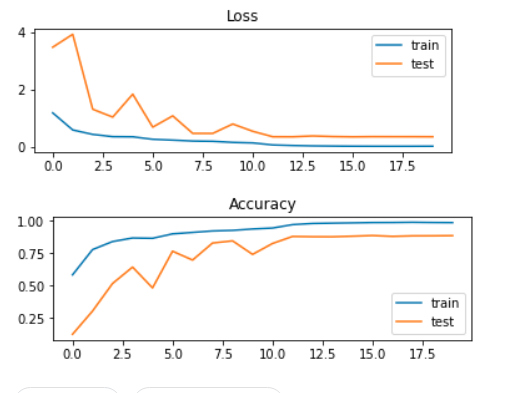

### Metrics Charts

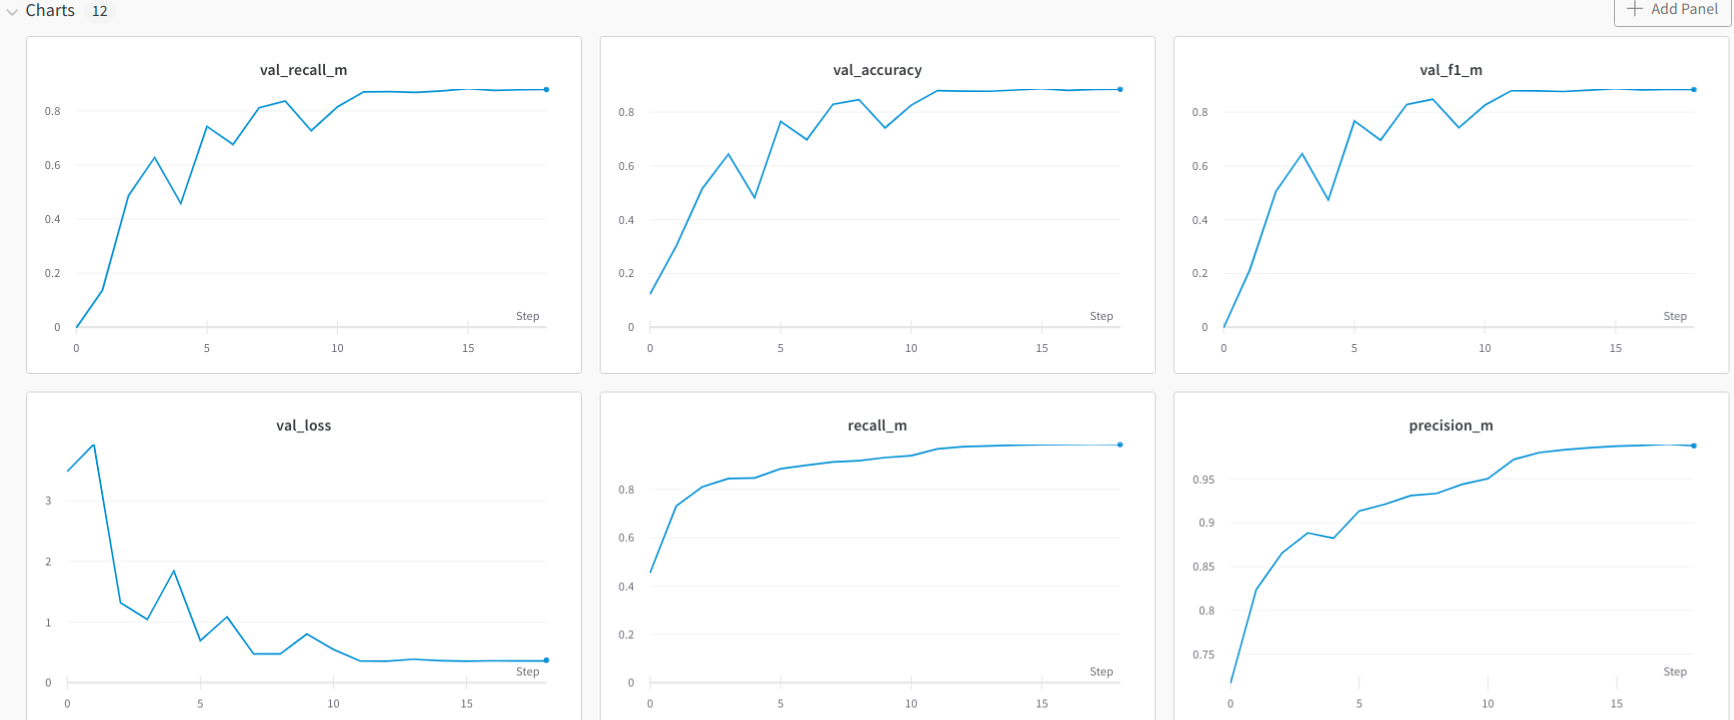

### Memory Utilization Charts

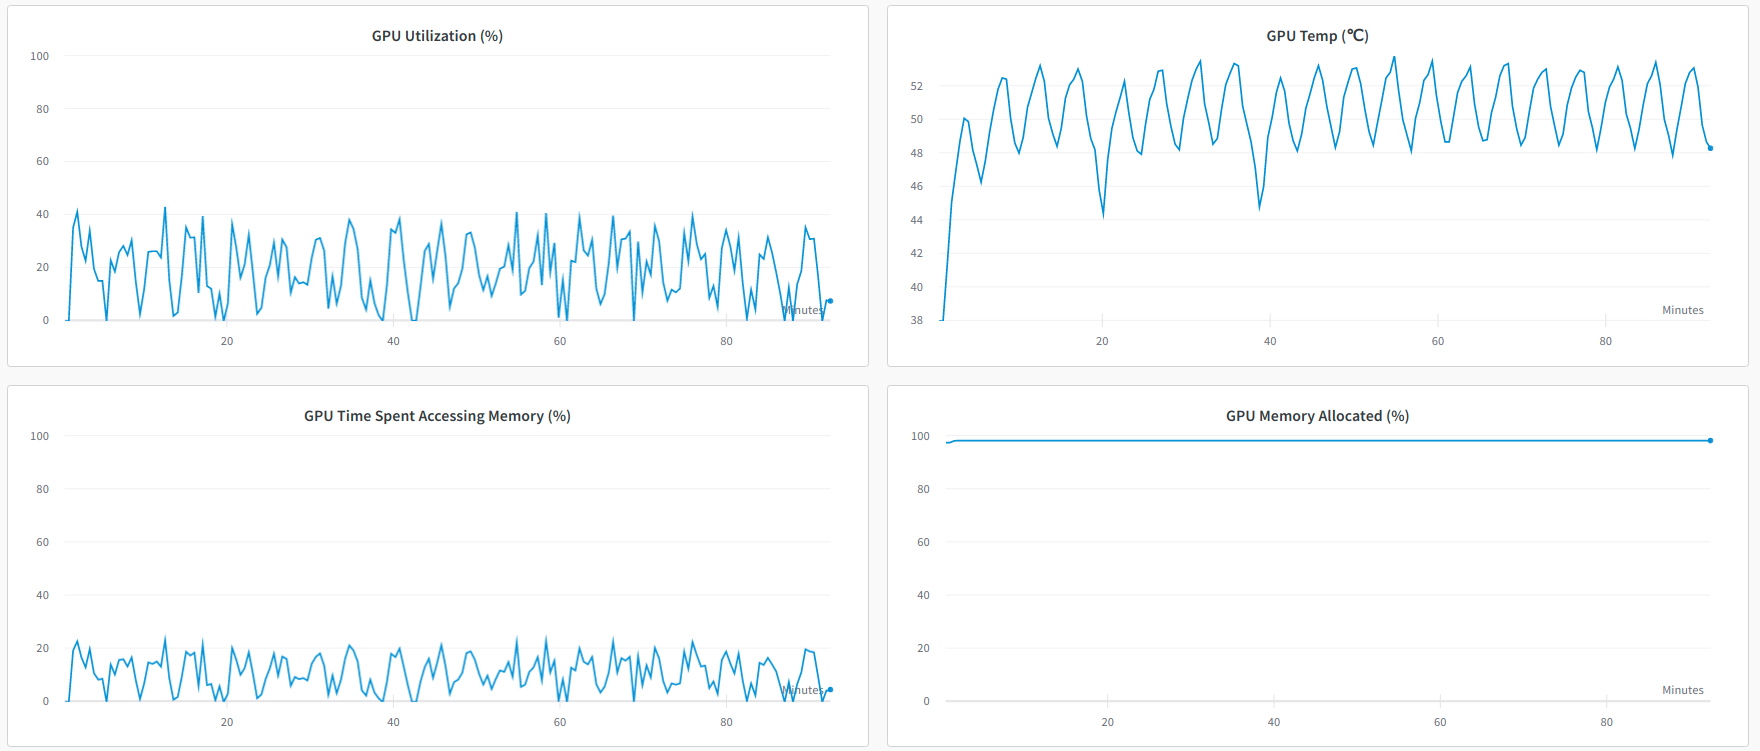

### Metrics report 

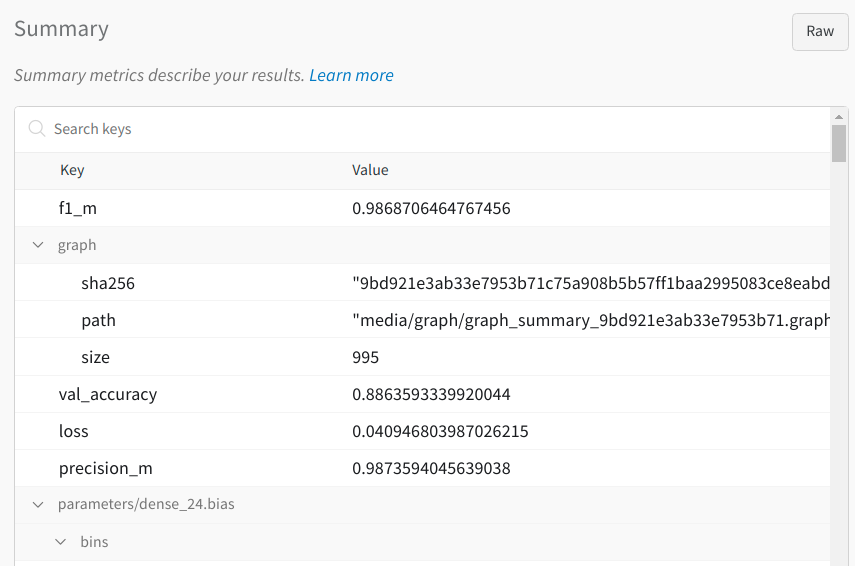
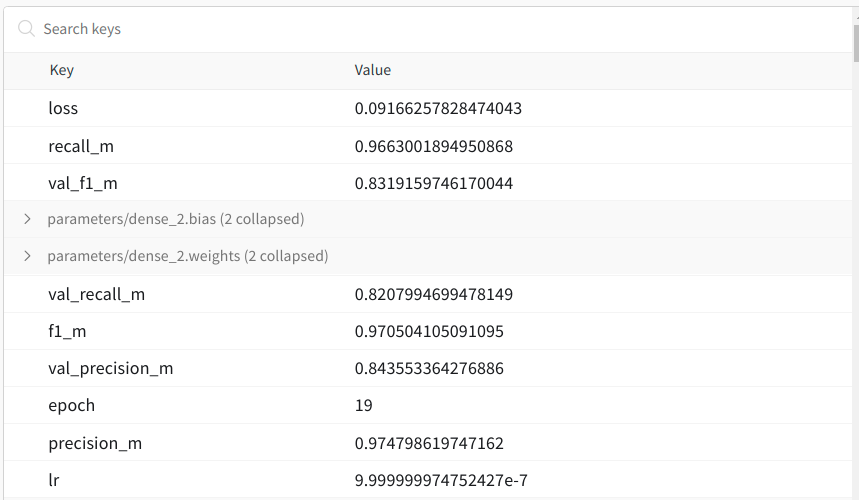


## Saved Model

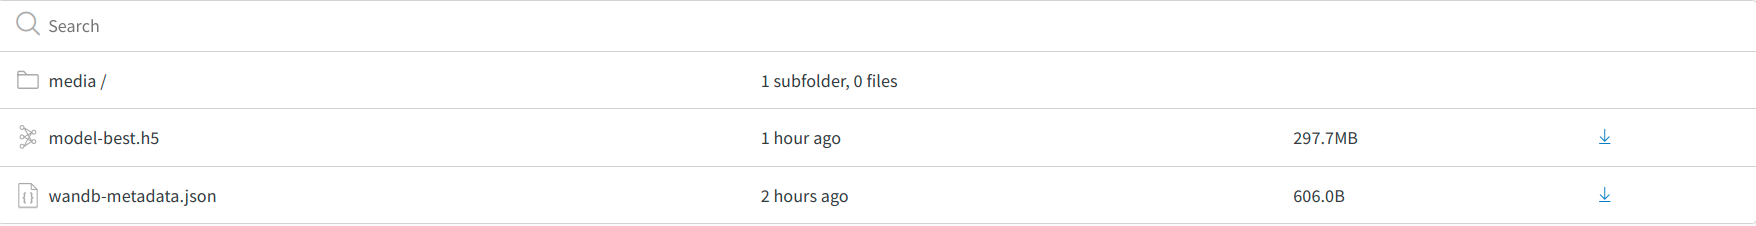

# Vision Transformers model


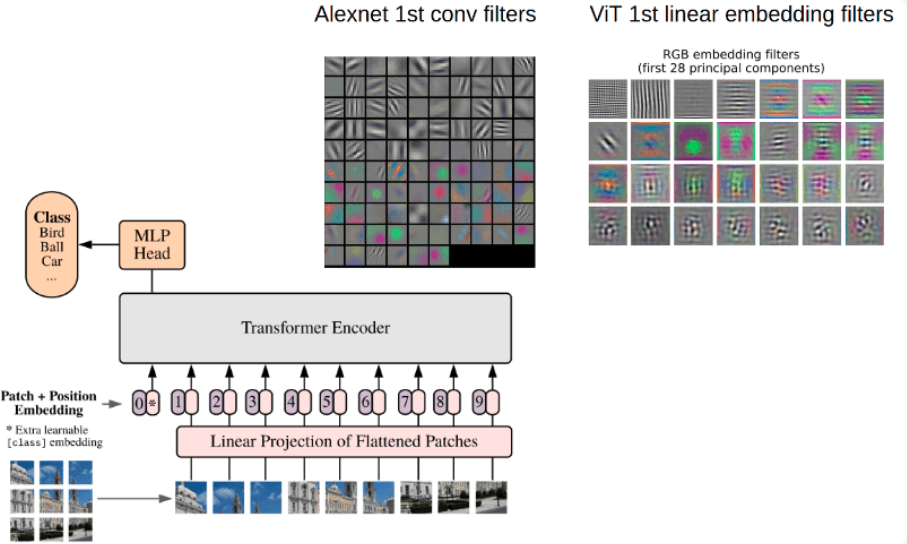

## The Next Model  is The Vision Transformer, which may Out-Perform all the previous Models if we have the right amount of data and the Ideal perameters 

In [ ]:
from tensorflow.keras import layers 
input_shape = (256,256,3)
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 64
num_epochs = 100
image_size = 256  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 8
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 4
mlp_head_units = [64, 32]  # Size of the dense layers of the final classifier

## Implement multilayer perceptron (MLP)


In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Implement patch creation as a layer




In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

## Implement the patch encoding layer


### The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim. In addition, it adds a learnable position embedding to the projected vector.


In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

## Build the ViT model


In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Create patches.
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(6, activation='softmax')(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    
    return model

In [ ]:
def run_experiment(model):
    
    learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy',
                                                patience = 2,
                                                verbose=1,
                                                factor=0.1,
                                                min_lr=0.000001)

    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

    model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_generator,validation_data = valid_generator, epochs = 1,callbacks = [learning_rate_reduction,wandb_callback])

    return history


vit_classifier = create_vit_classifier()
print(vit_classifier.summary())

In [ ]:

tf.keras.utils.plot_model(
    vit_classifier, to_file='base_model.png'
)

In [ ]:
history = run_experiment(vit_classifier)


> ### Metrics Charts

# DenseNet 
> ##  due to the longer path between the input layer and the output layer, the information vanishes before reaching its destination, DenseNet was developed specifically to improve the declined accuracy caused by the vanishing gradient in high-level neural networks. 

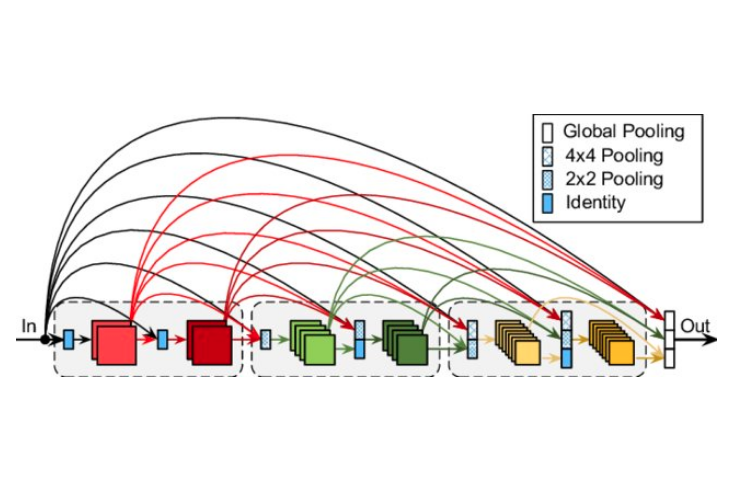

## Define The model 

In [ ]:
DenseNet = tf.keras.applications.DenseNet121(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256,256 ,NB_CHANNELS),
    pooling=None,
    
)
new_model = Sequential(name = 'DenseNet')
new_model.add(DenseNet)
new_model.add(GlobalAveragePooling2D())
new_model.add(Dense(512))
new_model.add(Dense(256))
new_model.add(Dense(6, activation='softmax'))
DenseNet = new_model
DenseNet.summary()

## Plot The model architecture

In [ ]:

tf.keras.utils.plot_model(
    DenseNet, to_file='base_model.png'
)

## Generate Data 

In [ ]:
train_generator, valid_generator = get_train_generator(df_train,df_test, image_dir = None, x_col = "Image_name", y_cols = "Plane", 
                        shuffle=True, batch_size=64, seed=1, target_w = 256, target_h = 256)

## Train The model 

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience = 2,
                                            verbose=1,
                                            factor=0.1,
                                            min_lr=0.000001)

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

DenseNet.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy',f1_m,precision_m, recall_m])
history = DenseNet.fit(train_generator,validation_data = valid_generator, epochs = 5,callbacks=[learning_rate_reduction,wandb_callback])


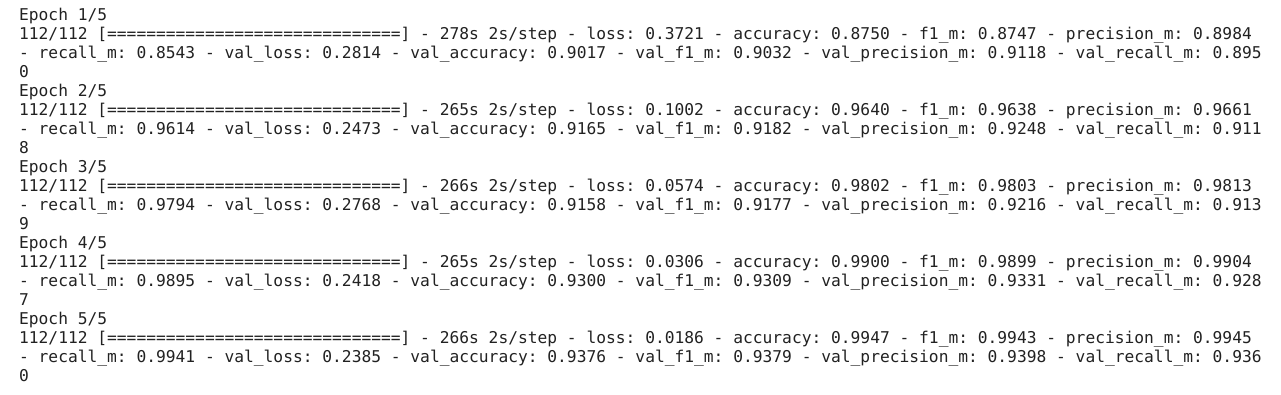

In [ ]:
from matplotlib import pyplot

# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

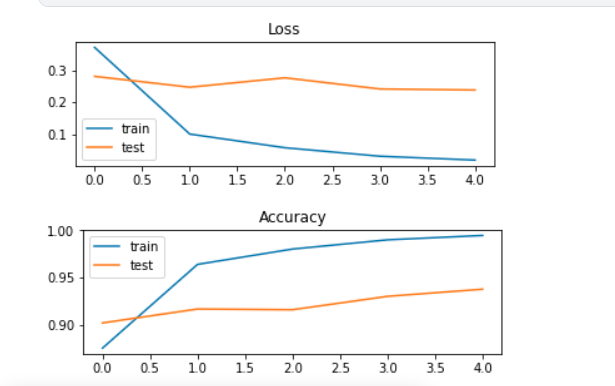

### Metrics Charts

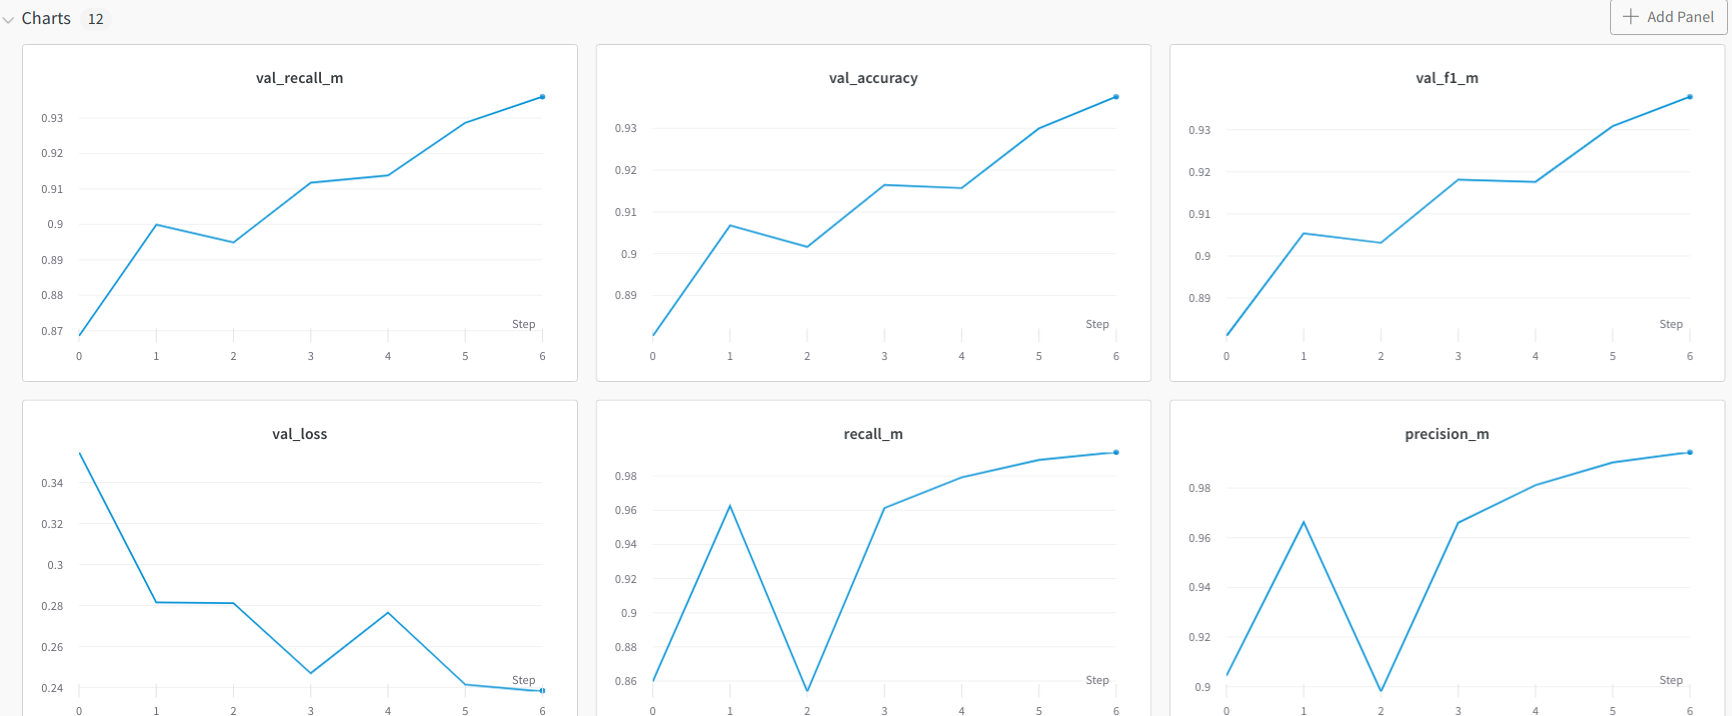

## Metrics Report 

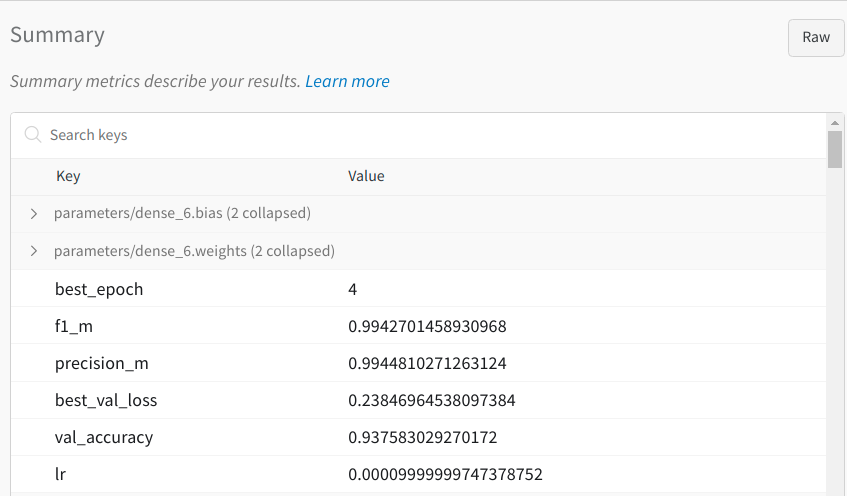

# VGG19
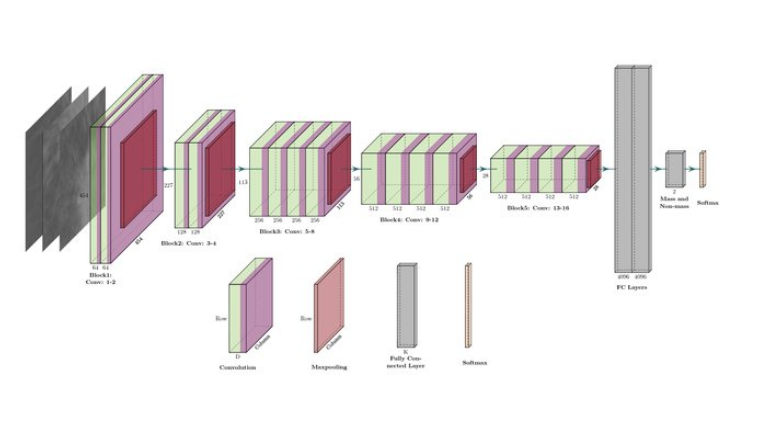

## Loading The model 

In [ ]:
VGG19 = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256,256 ,NB_CHANNELS),
    pooling=None,
    classifier_activation="softmax",
)
new_model = Sequential(name = 'VGG19')
new_model.add(VGG19)
new_model.add(GlobalAveragePooling2D())
new_model.add(Dense(512))
new_model.add(Dense(256))
new_model.add(Dense(6, activation='softmax'))
VGG19 = new_model
VGG19.summary()

In [ ]:

tf.keras.utils.plot_model(
    VGG19, to_file='base_model.png'
)

In [ ]:
train_generator, valid_generator = get_train_generator(df_train,df_test, image_dir = None, x_col = "Image_name", y_cols = "Plane", 
                        shuffle=True, batch_size=64, seed=1, target_w = 256, target_h = 256)

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [ ]:
    
learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy',
                                            patience = 2,
                                            verbose=1,
                                            factor=0.1,
                                            min_lr=0.000001)

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

VGG19.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy',f1_m,precision_m, recall_m])
history = VGG19.fit(train_generator,validation_data = valid_generator, epochs = 5,callbacks = [learning_rate_reduction,wandb_callback])


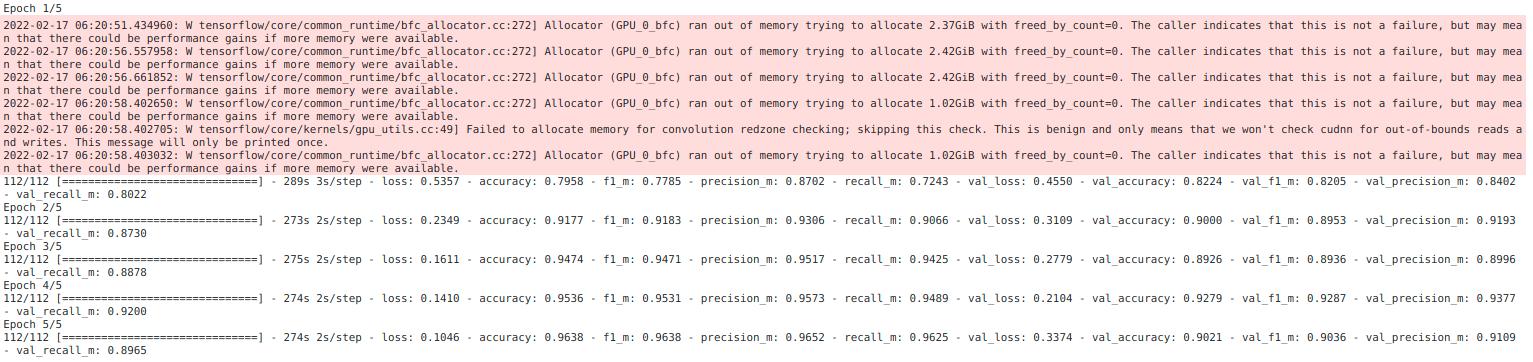

In [ ]:
VGG19.evaluate(valid_generator)

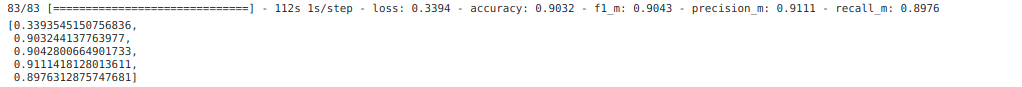

In [ ]:
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

> ### Metrics Charts

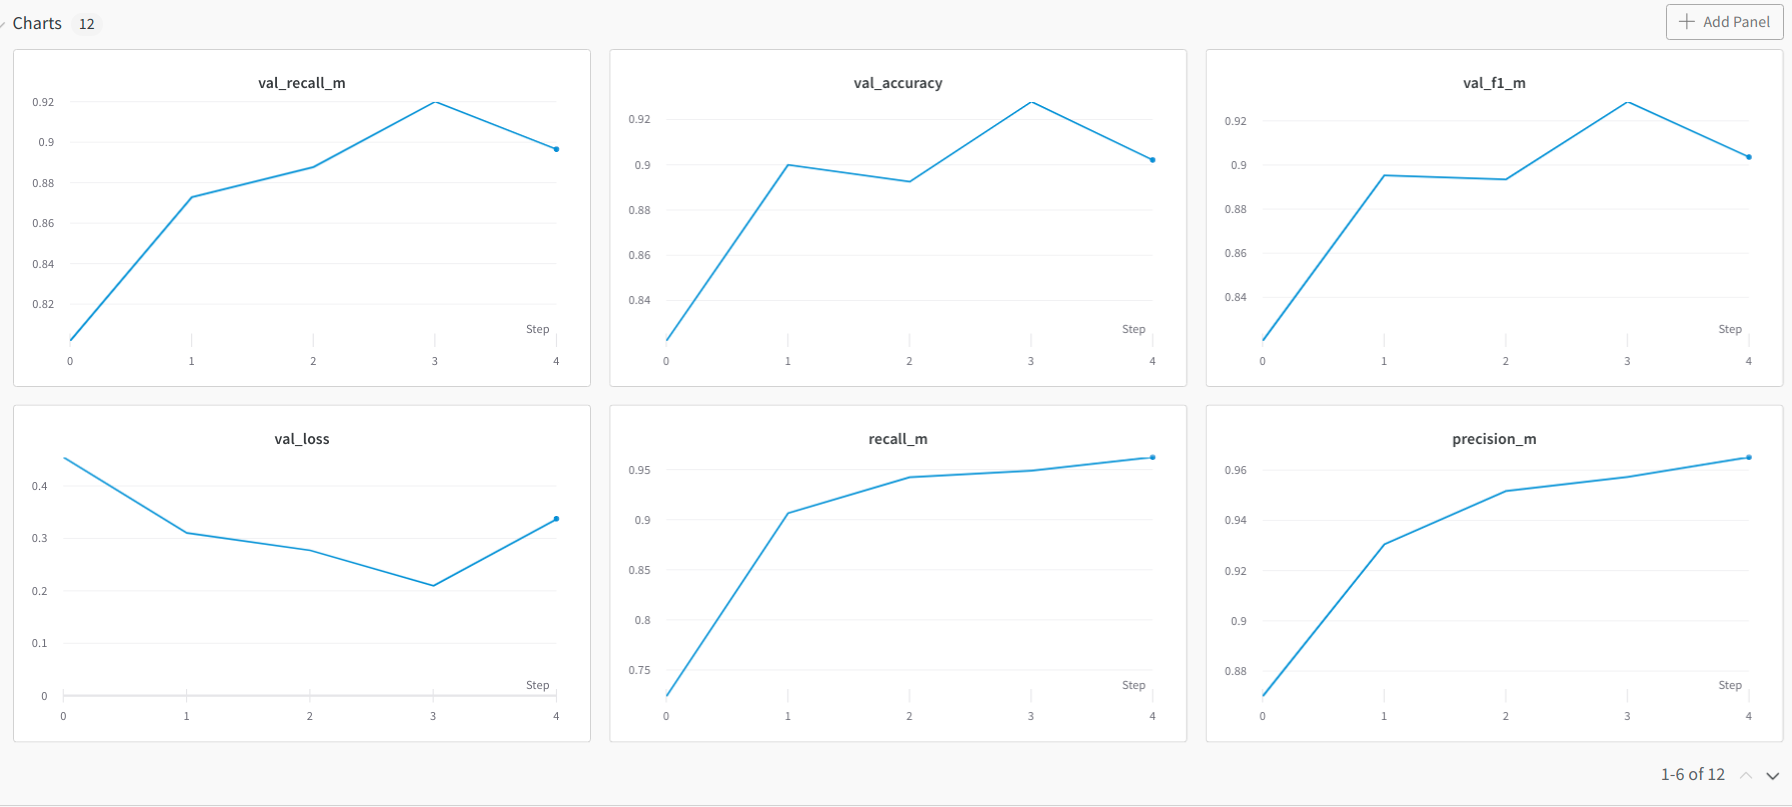

> ### Metrics Report 
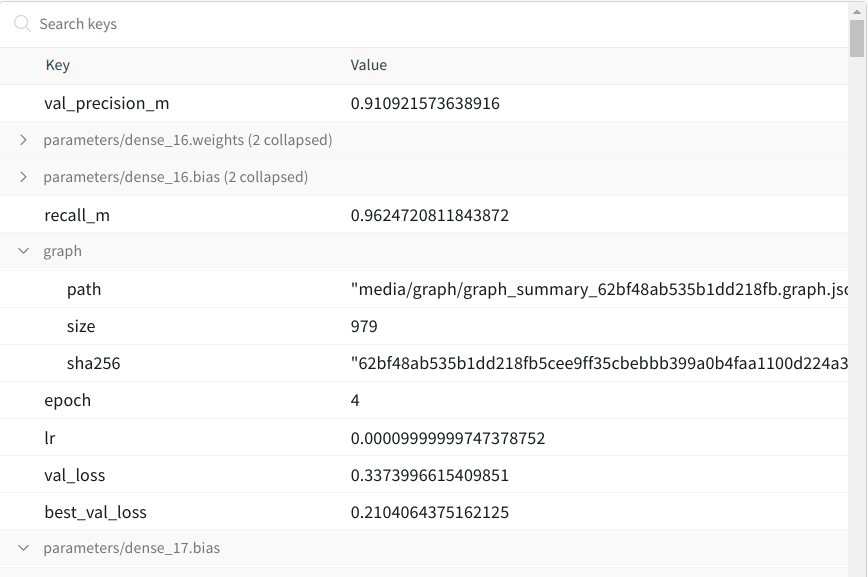

## Conclusion 

### base-line model 
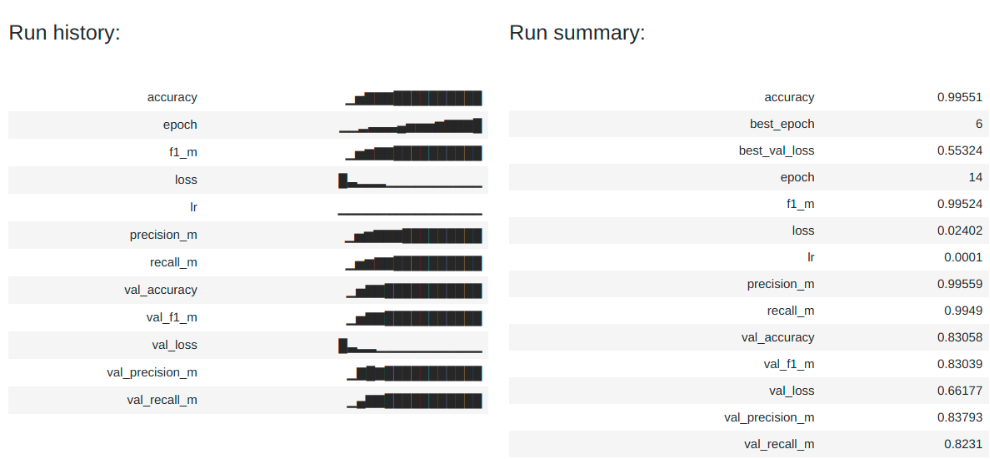

### EfficientNet 
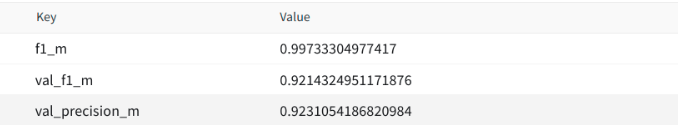

## Resnet50 
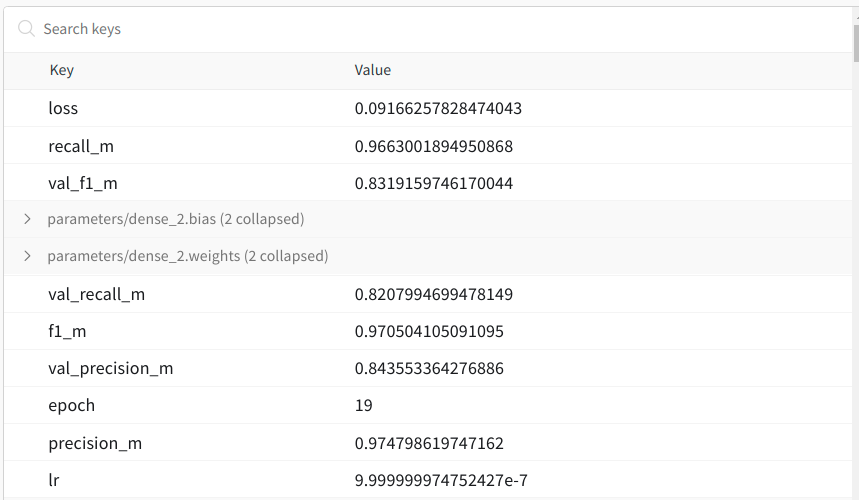

## VGG19 
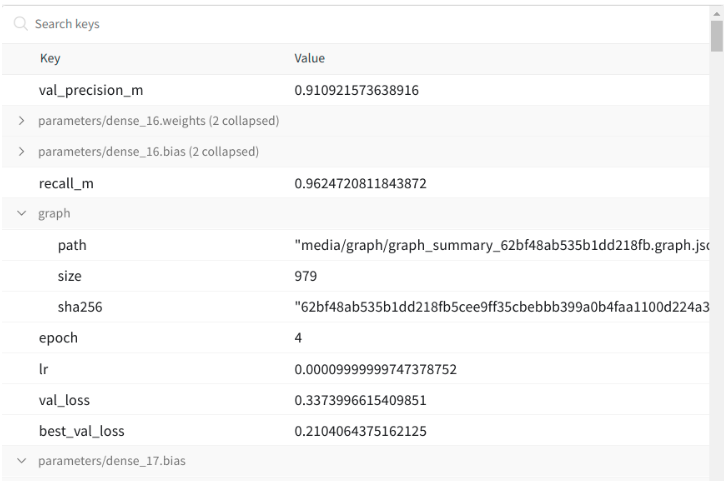

## DenseNet 
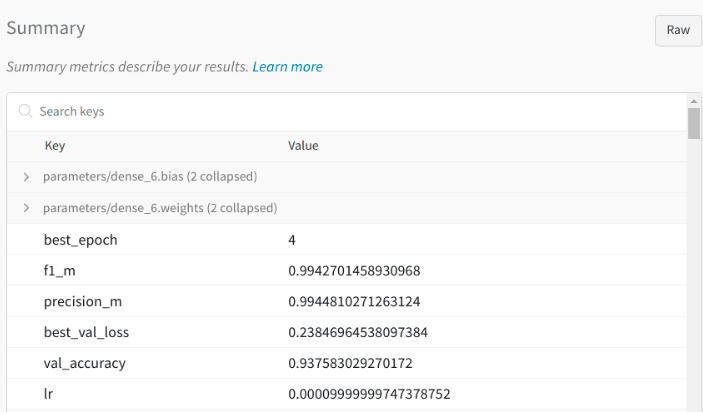

## We can't chose a model over another since we have limited ressources, But the best result we got until now is DenseNet 